# **Stripline - Solução pelo Método dos Elementos Finitos**


## **Grupo:**
###- Otávio Henrique Baudel Francisco - ohbf
###- Thiago Ramalho Magalhães - trm4

## **Módulos importados**

In [ ]:
import math
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262234135221764166/image.png?ex=6695daa5&is=66948925&hm=16bb83ada477760f29162de852de4f7bd688ce67d57c0e7064a4a479866139d1&=&format=webp&quality=lossless&width=550&height=340)

Desejamos aplicar o método dos elementos finitos para solucionar o potencial no plano x-y para uma stripline como a da imagem acima. A stripline possui potencial de 1V e está blindada por todos os lados por condutores de potencial 0V. Entre a fita e os condutores há um material dielétrico.

Para aplicar o método dos elementos finitos precisamos inicialmente discretizar o domínio observado na figura.

## **I - Discretização do Domínio**

Queremos utilizar uma malha simples como as mostradas no livro do Polycarpou, compostas por triângulos retângulos. Para isso, vamos definir as seguintes classes para representar os nós, os triângulos e a malha:

In [ ]:
class Node(object):
  def __init__(self, x_pos, y_pos, index):
    self.x = x_pos
    self.y = y_pos
    self.index = index

class Triangle(object):

  def __init__(self, node1, node2, node3):
    # Os nós devem estar listados no sentido anti-horário
    self.node1 = node1
    self.node2 = node2
    self.node3 = node3
    self.node_list = [self.node1, self.node2, self.node3]

    # A área é dada por metade do módulo do produto vetorial entre os vetores (x21,y21) e (x31,y31)
    self.area = (1/2)*((self.node2.x - self.node1.x)*(self.node3.y - self.node1.y) - (self.node3.x - self.node1.x)*(self.node2.y - self.node1.y))


class Mesh(object):
  def __init__(self, nodes, elements):
    self.nodes = np.array(nodes)
    self.elements = np.array(elements)

  def plot(self):
    # Método que plota a malha triangular gerada
    x = [i.x for i in self.nodes]
    y = [i.y for i in self.nodes]

    triangles = [[self.nodes.tolist().index(i.node1),
                  self.nodes.tolist().index(i.node2),
                  self.nodes.tolist().index(i.node3)] for i in self.elements]

    plt.figure(figsize=(10, 4))
    plt.triplot(x, y, triangles, color='blue')
    plt.xlabel('X(m)')
    plt.ylabel('Y(m)')
    plt.title('Malha triangular')
    plt.show()


A seguir vamos montar a malha em si. É preciso organizar os nós em linhas e colunas de forma que a quantidade de linhas seja ímpar e a quantidade de colunas seja um múltiplo de 5 + 1. Isso implica em Nx = 5K + 1 e Ny = 2k + 1 no código a seguir:

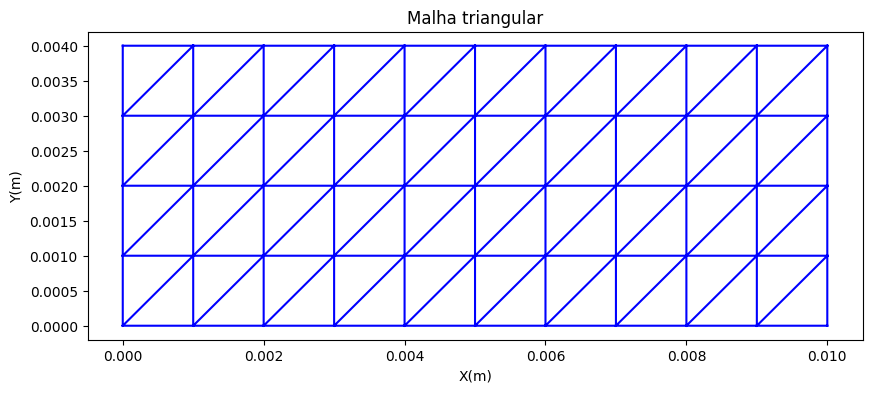

In [ ]:
height = 4e-3 # Altura total da malha
width = 10e-3 # Largura total da malha

Nx = 11 # Número de colunas de nós na malha
Ny = 5 # Número de linhas de nós na malha

dx = width / (Nx - 1) # Distância horizontal entre nós
dy = height / (Ny - 1) # Distância vertical entre nós

# Lista de nós
nodes = []
index = 0
for i in range(Ny):
  for j in range(Nx):
    node = Node(j*dx,i*dy, index)
    nodes.append(node)
    index += 1


# Lista de elementos (triângulos retângulos isósceles)
elements = [
    Triangle(nodes[Nx*i+(j//2)], nodes[Nx*(i+1)+(j//2)+1], nodes[Nx*(i+1)+(j//2)]) if j % 2 == 0
    else  Triangle(nodes[Nx*i+(j//2)], nodes[Nx*i+(j//2)+1], nodes[Nx*(i+1)+(j//2)+1])
    for i in range(Ny-1)
    for j in range(2*(Nx-1))
    ]
# Obs: Ny*i+(j/2) é o índice do primeiro nó de um triangulo,
# Obs: as duas listas começam do índice 0, ao contrário dos exemplos do Polycarpou, que começam a partir do índice 1

mesh = Mesh(nodes, elements)
mesh.plot()

## **II - Escolha das funções interpolação (de base, de forma)**

As funções de interpolação escolhidas para cada triângulo são planos no eixo xyV (o terceiro eixo sendo o próprio valor do potencial). As bases dessas funções de interpolação precisam ser escolhidas de forma que com elas seja possível formar qualquer plano que passe pelos 3 potênciais de cada um dos 3 nós do elemento. Podemos alcançar isso escolhendo 3 funções de base: N1, N2 e N3. Cada uma dessas bases está associada a um dos três nós do elemento triangular, e cada uma delas é um plano que apresenta potencial 1V para o nó ao qual está associada e 0V para os demais nós. As 3 bases para as funções de interpolação podem ser vistas na seguinte imagem:

![Alt Text](https://media.discordapp.net/attachments/656511583509413907/1262194860115492916/image.png?ex=6695b611&is=66946491&hm=75e3b39e3670cc4db1f48affcc54075a88b94fd28a08eabc82f9d9cc381ea735&=&format=webp&quality=lossless&width=550&height=171)

Essas bases podem ser melhor descritas utilizando um sistema interno de coordenadas, representado a seguir por ξ e η:

![Alt Text](https://media.discordapp.net/attachments/656511583509413907/1262196992088608890/image.png?ex=6695b80d&is=6694668d&hm=34e83cdfcc58fb7ce52ee77abc9c43434685fff173465ea435503514f136858d&=&format=webp&quality=lossless&width=550&height=249)

Neste novo sistema de coordenadas, as bases têm as seguintes fórmulas:


$\\N_1 = 1 - ξ - η \\ N_2 = ξ \\ N_3 = η$

## **III - Obter o sistema linear para um único elemento**

A obtenção do sistema linear para resolver a equação de Poisson vem de uma técnica chamada de "method of weighted residual" ou Abordagem de Galerkin. Antes de explicar esse método precisamos nos atentar ao fato de que estamos querendo resolver uma equação diferencial parcial de segunda ordem que segue a seguinte estrutura:

![Alt Text](https://media.discordapp.net/attachments/656511583509413907/1262201751550038116/image.png?ex=6695bc7c&is=66946afc&hm=98d26a27bb9f910e9d0d54c0583684c721dabc7720659b3e32146a691176aed8&=&format=webp&quality=lossless)

Onde, para a equação de Poisson temos:

$u = V \\ \alpha_x = \alpha_y = ϵ \\ \beta = 0 \\ g = -ρ_v$

Com isso, a abordagem de Garlekin propõe uma "weight funcion" ω que deve pertencer ao mesmo conjunto de funções que podem ser representadas pelas bases que estão sendo usadas para interpolar os elementos. A ideia agora é encontrar que função ω desse conjunto melhor se aproxima da solução para a equação diferencial parcial. Para isto, usa-se conceitos da álgebra linear a fim de obter uma "projeção" da solução ótima no nosso espaço de funções que contém as possíveis funções ω (ou seja, o espaço formado pelas bases N1, N2, N3). Assim, aplica-se o seguinte produto interno:

![Alt Text](https://media.discordapp.net/attachments/656511583509413907/1262204929070600193/image.png?ex=6695bf71&is=66946df1&hm=042ddfc6445f203d4eb8252bc704fb6735df6434b3a472965d7b83909cb9c621&=&format=webp&quality=lossless)

Fazendo uma manipulação obtém-se a seguinte expressão:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262205286077436015/image.png?ex=6695bfc6&is=66946e46&hm=d169ae2aef10e171fa18545ae4b676fe0b5b1b544369e6d67e93ea73ca41ee72&=&format=webp&quality=lossless)

Finalmente, utilizando o Teorema de Green é possível substituir o primeiro termo por uma integral de linha equivalente na borda do elemento. É válido ressaltar, no entanto, que ao contrário das integrais de linha com a qual estamos acostumados, o que contribuirá para a integral não será a componente do campo na direção de integração, e sim a componente normal ao contorno do elemento. A figura a seguir mostra como fica a expressão após substituir o primeiro termo pela integral de linha e passar para o lado direito da igualdade:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262207392536461352/image.png?ex=6695c1bd&is=6694703d&hm=2cecef947ecc56f25f5b9a8824f35f353cb68725d62a8dae203c5b24cb519e68&=&format=webp&quality=lossless)

Nesta etapa podemos finalmente substituir o ω pela soma ponderada das funções de base, e obter a seguinte expressão:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262207984021274624/image.png?ex=6695c24a&is=669470ca&hm=d67253186781a1fa9a402c9aa76c9f1690f016c845350bff31e7489304513eb6&=&format=webp&quality=lossless)

A imagem está generalizada para qualquer número n de nós por elemento, mas no caso da malha triangular que usamos n será sempre 3. Nesta forma, a expressão pode finalmente ser mapeada para a multiplicação de matrizes:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262208456413286450/image.png?ex=6695c2ba&is=6694713a&hm=fc99ba11a162d3ab626b09918161cca5a66d7bc31e38fb742a5235f6a5295dfe&=&format=webp&quality=lossless)

Onde:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262208808021921862/image.png?ex=6695c30e&is=6694718e&hm=bf0bec4efbc981ed19e154c99e55a0d598ee3a3f3835461ad83365d3c1a716eb&=&format=webp&quality=lossless)

Observando as identidades acima podemos notar algumas coisas:

1) A matriz T depende de β, que para a equação de Poisson já vimos que é 0. Portanto a matriz T será ignorada por completo.

2) O vetor f depende de g, que na equação de Poisson é o negativo da carga volumétrica. No entanto, para este problema, assim como nos problemas que resolvemos em sala de aula, podemos fazer uma simplificação e considerar a densidade volumétrica de carga nula dentro do dielétrico. Essa simplificação é possível porque a carga livre é desprezível em um dielétrico ideal, e a carga de polarização pode ser ignorada quando pensamos em termos do vetor deslocamento. Assim, o vetor f também será ignorado por completo

3) O vetor p depende da integral de linha do produto escalar entre o vetor delocamente e o versor normal ao contorno do elemento. Quando todos os elementos forem considerados na montagem de um sistema linear global, a integral será cancelada para a maioria dos elementos, visto que os segmentos nos quais as integrações são feitas normalmente são comuns entre 2 triângulos, de forma que a mesma integração é feita 2 vezes porém com o sinais contrários. Os únicos elementos que possuem o vetor p são os elementos na borda da malha, com segmentos que não são compartilhados com outro triângulo. No entanto, mesmo para esses elementos de borda, a integral de linha é desconsiderada caso a condição de contorno do segmento de borda seja uma condição de contorno de Dirichlet. Uma condição de contorno de Dirichlet é uma que define o valor do potencial na borda mas não sua derivada, o que é exatamente o caso do nosso problema. Desta forma, o vetor p também será desconsiderado por completo.

Assim, o sistema linear que sobrou é apenas este:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262216717682348072/image.png?ex=6695ca6c&is=669478ec&hm=8cc2bf83965800e54bbd1699e2646db11867283fd2cc64f5f5869d185467b413&=&format=webp&quality=lossless)

Com isso, a única coisa que precisamos encontrar para montar o sistema linear de cada elemento são os elementos da matriz M, lembrando que para a malha triangular que utilizamos n = 3 e portanto a matriz será apenas 3x3. Resolvendo a integral obtemos os seguintes valores para os 9 elementos:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262218347748130898/image.png?ex=6695cbf0&is=66947a70&hm=5c921b869ea4cf9782397699a6d2cc62e908aa8070170fe5f115f7563bad4ee6&=&format=webp&quality=lossless&width=481&height=660)

Onde $A_e$ é a área do elemento triangular. Como podemos ver, os elementos dependem de $\alpha_x$ e $\alpha_y$, que para a equação de Poisson são iguais a $ϵ$. No caso do nosso problema, $ϵ = ϵ_r*ϵ_0$. Essa constante é definida no seguinte código:

In [ ]:
eps0 = const.epsilon_0 # Permissividade elétrica do vácuo
epsr = 4.5 # Permissividade elétrica do dielétrico (Como não foi fornecido um valor específico assumimos o valor para o FR4)
eps = eps0 * epsr # Assumimos um dielétrico linear e desenvolvemos as contas a partir de um eps = eps0 * epsr

Por fim, a seguir está a definição de um método da classe Triangle que obtém esses 9 coeficientes da matriz do elemento a partir das fórmulas encontradas acima:

In [ ]:
def get_matrix(self, eps):

  x13 = self.node1.x - self.node3.x
  x21 = self.node2.x - self.node1.x
  x32 = self.node3.x - self.node2.x

  y12 = self.node1.y - self.node2.y
  y23 = self.node2.y - self.node3.y
  y31 = self.node3.y - self.node1.y

  m11 = -(eps/(4*self.area))*(y23**2 + x32**2)
  m12 = m21 = -(eps/(4*self.area))*(y23*y31 + x32*x13)
  m13 = m31 = -(eps/(4*self.area))*(y23*y12 + x32*x21)
  m22 = -(eps/(4*self.area))*(y31**2 + x13**2)
  m23 = m32 = -(eps/(4*self.area))*(y31*y12 + x13*x21)
  m33 = -(eps/(4*self.area))*(y12**2 + x21**2)

  matrix = np.matrix(
      [[m11, m12, m13],
        [m21, m22, m23],
        [m31, m32, m33]]
  )
  return matrix

# Adicionando o novo método "get_matrix" à classe "Triangle"
Triangle.get_matrix = get_matrix

## **IV - Obter o sistema linear global (todos os elementos)**

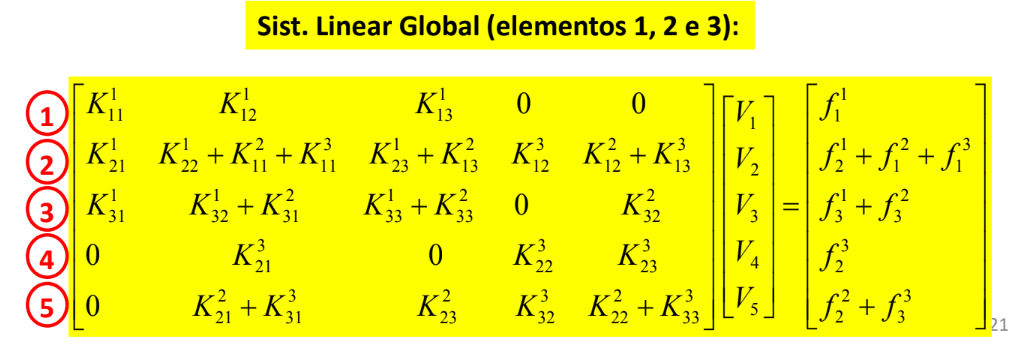

O sistema linear global é representado por uma matriz quadrada NxN onde N é o total de nós da malha. Ela é formada a partir de uma regra específica, em que ela é inicializada como nula e seus elementos começam a ser somados aos elementos das matrizes menores relacionadas a cada elemento. Basicamente, faz-se um loop que itera em todos os triângulos, e para cada combinação 2 a 2 de nós desse triângulo se adiciona o elemento $M_{i,j}$ da matriz do triângulo ao elemento $K_{k,l}$ da matriz global, onde i e j representam os índices locais dos dois nós e k e l representam os índices globais dos mesmos nós. Basicmanete segue-se o seguinte algoritmo do matlab:

![Alt_text](https://media.discordapp.net/attachments/656511583509413907/1262223655207964862/image.png?ex=6695d0e2&is=66947f62&hm=415dcaa2ffb21ed8627a929e3c7ee07dc7f0768d6a4c0e4bf826b99f63371ad1&=&format=webp&quality=lossless)

Uma regra similar é seguida para montagem do vetor b ao lado direito da igualdade. No entanto, como todos os sistemas menores de cada triângulo possuem um vetor nulo do lado direito da igualdade, o vetor b global será também um vetor nulo, só que agora um vetor nulo de dimensão N (para N nós na malha). Com isso, encontrar o sistema global restringe-se apenas a encontrar a matriz global. A função que monta tal matriz global pode ser vista a seguir:

In [ ]:
def assemble_global_matrix(nodes, elements):

  global_matrix = np.zeros((len(nodes), len(nodes)))

  for e in elements:
    for i, n1 in enumerate(e.node_list):
      for j, n2 in enumerate(e.node_list):
        matrix = e.get_matrix(eps) # Matriz do elemento "e" correspondente à iteração
        global_matrix[n1.index][n2.index] += matrix[i, j]
  return global_matrix

In [ ]:
global_matrix = assemble_global_matrix(nodes, elements)

## **V - Impor condições de contorno**

Existem nós cujo potencial já é conhecido, e são aqueles localizados na borda da malha ou na stripline em si. A seguir são definidas funções que checam o pertencimento ou não de um nó a um desses dois grupos:

In [ ]:
def strip_cond(node):
  # Função que recebe um nó e retorna "True" somente se o nó pertencer à fita
  if((node.y == 0.002) and (0.004 <= node.x <= 0.006)): return True
  else: return False

def x_limit_cond(node):
  # Função que recebe um nó e retorna True somente se o nó pertence às bordas laterais
  if(node.x == 0): return True
  elif(node.x == 10e-3): return True
  else: return False

def y_limit_cond(node):
  # Função que recebe um nó e retorna True somente se o nó pertece às bordas de cima ou de baixo
  if(node.y == 4e-3): return True
  elif(node.y == 0): return True
  else: return False

def check_conditions(node):
  # Função que recebe um nó e retorna seu potencial se este for um nó de contorno ou -1 se não for
  if(strip_cond(node)): return 1 #1 volt
  elif(x_limit_cond(node) or y_limit_cond(node)): return 0 #0 volt
  else: return -1 #-1 está sendo usado para simbolizar um potencial ainda desconhecido

Utilizar o conhecimento que temos do potencial dos nós a nosso favor significa impor as condições de contorno para reduzir o problema. Basicamente, para todo iésimo nó que por acaso faça parte das condições de contorno passaremos a iésima coluna da matriz global para o lado direito com sinal negativo e multiplicando o potencial conhecido. Isto não é nenhum truque avançado, é apenas manipulação básica de sistemas lineares. Após passar todas essas colunas para o lado direito, a matriz global deixa de ser uma matriz quadrada. O motivo disso é que agora o sistema passou a ter linhas linearmente dependentes de outras linhas, pois a quantidade de variáveis desconhecidas diminuiu enquanto as linhas permaneceram intactas. Para corrigir isso, para cada iésima coluna que eliminarmos da matriz, também eliminaremos a iésima linha da matriz e do vetor b, que podemos garantir que será uma linha redundante. Assim, teremos um sistema reduzido. A função a seguir realiza tais imposições da condição de contorno e retorna a matriz reduzida e o vetor b resultante:

In [ ]:
def apply_conditions(nodes, global_matrix):
  #Função que recebe a matriz global e a lista de nós e devolve a matriz global reduzida e o vetor b resultante

  b_vector = np.zeros(len(nodes))

  for n in nodes:
    vi = check_conditions(n)
    if (vi != -1):
      b_vector -= global_matrix[:, n.index] * vi

  indices_to_delete = []
  for n in nodes:
    vi = check_conditions(n)
    if (vi != -1):
      indices_to_delete.append(n.index)

  global_matrix = np.delete(global_matrix, indices_to_delete, 0)
  global_matrix = np.delete(global_matrix, indices_to_delete, 1)

  b_vector = np.delete(b_vector, indices_to_delete)
  return global_matrix, b_vector

In [ ]:
global_matrix_deleted, b_vector_deleted = apply_conditions(nodes, global_matrix)

## **VI - Resolver o sistema linear**

O sistema linear que obtemos pode ser resolvido facilmente pela função np.linalg.solve() da biblioteca Numpy:

In [ ]:
boundless_solution = np.linalg.solve(global_matrix_deleted, b_vector_deleted)

Resolvendo esse sistema obtemos os potenciais dos nós que antes eram desconhecidos. Agora podemos unir essas soluções obtidas aos potenciais que já conhecíamos para obter uma solução completa:

In [ ]:
# Unindo a solução dos nós fora do contorno aos potenciais que já conheciamos dos nós de contorno
def combine_solutions(nodes, boundless_solution):
# Função que retorna um array com o potencial de todos os nós, sejam eles de borda ou não
  i = 0
  complete_solution = np.zeros(len(nodes));
  for n in nodes:
    vi = check_conditions(n)
    if vi != -1:
      # Se o nó pertence ao contorno, seu potencial será a condição de contorno já definida
      complete_solution[n.index] = vi
    else:
      # Se o nó não pertence ao contorno, seu potencial será dado pelo sub-sistema que acabou de ser resolvido
      complete_solution[n.index] = boundless_solution[i]
      i += 1 #A variável i garante que o valores do vetor "boundless_solution" sejam transferidos em ordem
  return complete_solution

In [ ]:
complete_solution = combine_solutions(nodes, boundless_solution)

Obtemos acima o resultado final na forma de um array de potenciais, mas para melhor visualizar a solução precisamos organizá-la em linhas e colunas conforma a malha original:

In [ ]:
# Reorganizando a solução em linhas e colunas (Ny por Nx)
solution_reshaped = complete_solution.reshape((Ny, Nx))

Por fim, recorremos à biblioteca matplot.lib para visualizar a solução obtida:

In [ ]:
def plot_potentials(solution_reshaped, width, height):
  # Declarando a figura que será plotada
  plt.figure(figsize=(10, 6))

  # Definindo a paleta de cores para a figura e discretizando-a para um número finito de cores
  levels = np.linspace(0, 1, 17)  # 11 níveis discretizados entre 0 e 1
  cmap = plt.get_cmap('jet', len(levels) - 1)  # Obtendo o "colormap" para os intervalos discretizados
  norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

  # Definindo os domínios do eixo X e do eixo Y
  extent = [0, width, 0, height]

  # Passando para a função "imshow" a função de interpolação, o color map, a norma, e a proporção do plot
  plt.imshow(solution_reshaped, interpolation='bilinear', cmap=cmap, norm=norm, origin='lower', extent=extent)

  # Adicionando legenda de cores do lado direito para melhor legibilidade
  plt.colorbar(label='Potencial (V)')

  # Labels dos eixos X e Y
  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')

  # Label informando a quantidade N de nós utilizados
  plt.title('Distribuição do Potencial na Malha para N = ' + str(solution_reshaped.size))

  # Exibindo o plot
  plt.show()

Repare que na função que plota o potencial existe um parâmetro chamado "interpolation", onde selecionamos a opção "bilinear". O motivo de tal escolha é que o filtro "bilinear" é a opção de interpolação do matplotlib que mais se equipara às funções de interpolação lineares que utilizamos como base para a abordagem de Galerkin (Como diz o nome, a interpolação bilinear usa funções lineares no eixo x e y para estimar o valor de um ponto desconhecido baseado em pontos próximos com valor conhecido). Assim, acreditamos que esse filtro melhor ilustra os resultados obtidos.

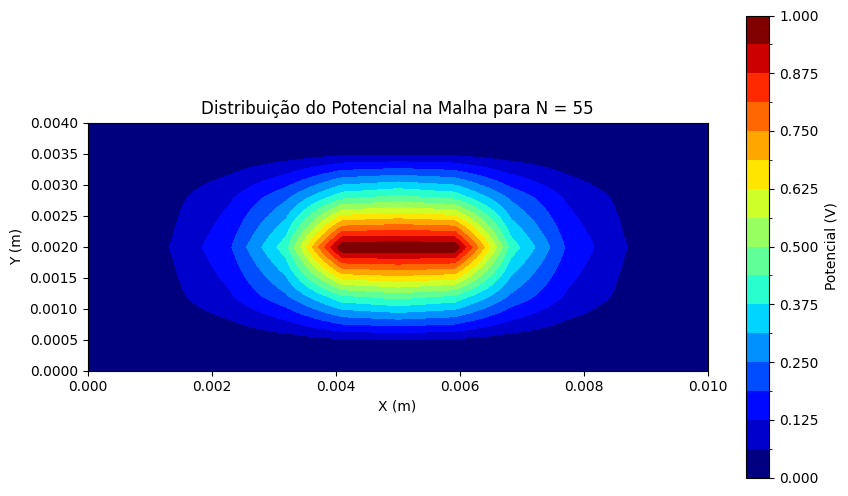

In [ ]:
plot_potentials(solution_reshaped, width, height)

Notamos na imagem acima uma distribuição de potencial bastante condizente com o que se esperaria de um problema assim. Se acompanharmos a imagem horizontalmente saindo da fita e indo até as bordas observamos um potencial alto de 1V que decai rapidamente perdo da fita e vai decaindo cada vez mais devagar longe da fita, evidenciando uma concavidade bem íngreme do pontencial e portanto uma densidade de carga elevada. Em contrapartida se acompanharmos do meio da fita verticalmente até a borda de cima observamos um decaimento de potencial quase constante, evidenciando uma curvatura menor e portanto menos conecntração de carga. Assim, concluímos a partir da imagem que a carga da fita está se concentrando em suas extremidades, o que é condiz bastante com o que se espera teoricamente. Assim, podemos ter uma alta confiança de que a solução numérica com método dos elementos finitos está correta.

## **VII - Repetir os passos para diferentes valores de N**

Para ver como a granularidade da malha afeta os resultados obtidos, vamos repetir o método dos elementos finitos para diferentes números de nós. No entanto, é válido ressaltar que todas as configurações dos nós devem obedecer a regra Nx = 5K + 1 e Ny = 2K + 1 para que sempre existam 2 nós das extremidades da fita.

In [ ]:
num_repetitions = 9

#O código a seguir é similar à formação da malha no começo do notebook, porém todas as variáveis estão dentro de um array maior de tamanho num_repetitions
Nx_list = [(i + 1) * 5 + 1 for i in range(num_repetitions)]
Ny_list = [(i + 1) * 2 + 1 for i in range(num_repetitions)]

dx_list = [width / (Nx_list[i] - 1) for i in range(num_repetitions)]
dy_list = [height / (Ny_list[i] - 1) for i in range(num_repetitions)]

# Lista de nós
nodes_lists = [[] for _ in range(num_repetitions)]
for i in range(num_repetitions):
    index = 0
    for j in range(Ny_list[i]):
        for k in range(Nx_list[i]):
            node = Node(k * dx_list[i], j * dy_list[i], index)  # Note that j * dx and k * dy are for each repetition
            nodes_lists[i].append(node)
            index += 1



# Lista de elementos (triângulos retângulos isósceles)
elements_lists = [[] for _ in range(num_repetitions)]
for i in range(num_repetitions):
    elements_lists[i] = [
        Triangle(nodes_lists[i][Nx_list[i] * j + (k // 2)], nodes_lists[i][Nx_list[i] * (j + 1) + (k // 2) + 1], nodes_lists[i][Nx_list[i] * (j + 1) + (k // 2)]) if k % 2 == 0
        else Triangle(nodes_lists[i][Nx_list[i] * j + (k // 2)], nodes_lists[i][Nx_list[i] * j + (k // 2) + 1], nodes_lists[i][Nx_list[i] * (j + 1) + (k // 2) + 1])
        for j in range(Ny_list[i] - 1)
        for k in range(2 * (Nx_list[i] - 1))
    ]


# Assemble global matrix for each repetition
global_matrices = [assemble_global_matrix(nodes_lists[i], elements_lists[i]) for i in range(num_repetitions)]

# Apply conditions and solve the system
global_matrices_deleted = []
b_vector_deleted = []
for i in range(num_repetitions):
    gm, bv = apply_conditions(nodes_lists[i], global_matrices[i])
    global_matrices_deleted.append(gm)
    b_vector_deleted.append(bv)

boundless_solutions = [np.linalg.solve(global_matrices_deleted[i], b_vector_deleted[i]) for i in range(num_repetitions)]
complete_solutions = [combine_solutions(nodes_lists[i], boundless_solutions[i]) for i in range(num_repetitions)]
solutions_reshaped = [complete_solutions[i].reshape((Ny_list[i], Nx_list[i])) for i in range(num_repetitions)]


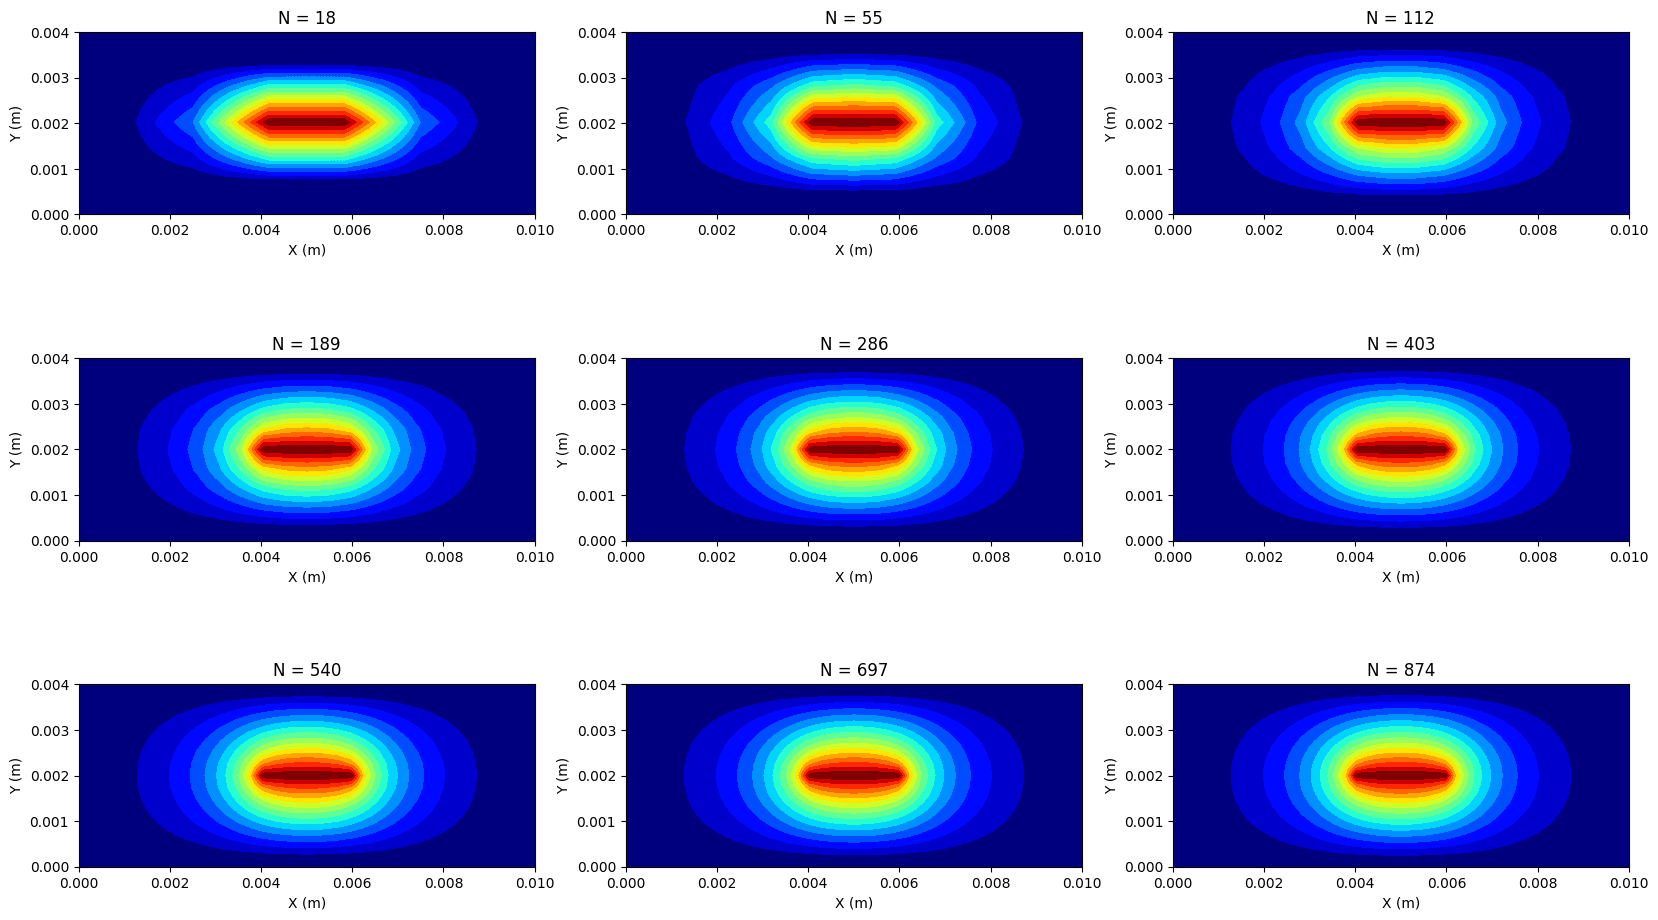

In [ ]:
def plot_potentials_3x3(solutions, width, height):
  # Declarando a figura que será plotada
  plt.figure(figsize=(20, 12))

  # Definindo a paleta de cores para a figura e discretizando-a para um número finito de cores
  levels = np.linspace(0, 1, 17)  # 11 níveis discretizados entre 0 e 1
  cmap = plt.get_cmap('jet', len(levels) - 1)  # Obtendo o "colormap" para os intervalos discretizados
  norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

  # Definindo os domínios do eixo X e do eixo Y
  extent = [0, width, 0, height]

  # Passando para a função "imshow" a função de interpolação, o color map, a norma, e a proporção do plot
  for i in range(3):
    for j in range(3):
      plt.subplot(3, 3, i*3+j+1)
      plt.imshow(solutions[i*3+j], interpolation='bilinear', cmap=cmap, norm=norm, origin='upper', extent=extent)

      # Labels dos eixos X e Y
      plt.xlabel('X (m)')
      plt.ylabel('Y (m)')

      # Label informando a quantidade N de nós utilizados
      plt.title('N = ' + str(solutions[i*3+j].size))

  # Exibindo o plot
  plt.show()

# Plotting the results
plot_potentials_3x3(solutions_reshaped, width, height)


Como podemos ver, uma quantidade maior de nós oferece uma solução mais precisa, e os resultados parecem convergir conforme o número de nós aumenta. No entanto, mesmo que um N elevado seja desejado, notamos que o método dos elementos finitos juntamente com as funções de interpolação escolhidas se mostraram  bastante eficientes em estimar o potencial mesmo para uma malha bem pequena, visto que as primeiras malhas não estão tão distantes da última. Assim, podemos concluir que o método dos elementos finitos se mostrou bem interessante tanto do ponto de vista da acurácia quanto do ponto de vista da complexidade computacional. O tamanho ideal de malha deve ser aquele preciso o bastante para nossas necessidades sem que o custo do algoritmo se eleve desnecessariamente.